In [33]:
from predict import Patient, concordance_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

In [5]:
input_data = pd.read_csv('./data/input_data3.csv')
input_data.columns

Index(['pID', 'age', 'detection', 'tumour_size', 'tumour_grade', 'nodes', 'er',
       'her2', 'ki67', 'chemo_generation', 'hormonetherapy', 'trastuzumab',
       'bisphosphonates', 'event', 'duration'],
      dtype='object')

In [3]:
estimator = CoxPHSurvivalAnalysis()
y = input_data[['event','duration']] #目的変数 
X = input_data.drop(columns=['event','duration','pID']) #説明変数

#dtypeの指定 ?はbool型　i8はint64
tp = np.dtype([('event','?'), ('duration', 'i8')])

structured_y = np.zeros(len(y), dtype=tp)
structured_y['event'] = y['event']
structured_y['duration'] = y['duration']
estimator.fit(X,structured_y)

CoxPHSurvivalAnalysis()

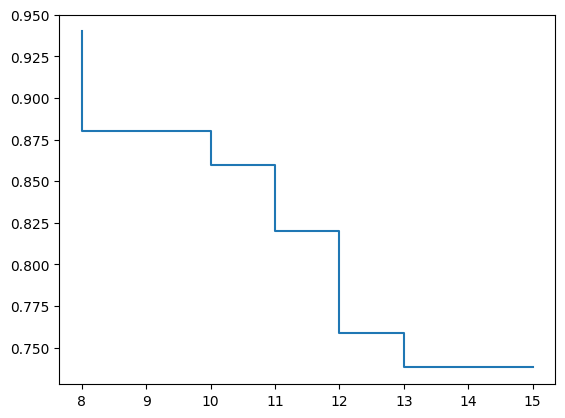

In [4]:
x, y_k = kaplan_meier_estimator(structured_y['event'], structured_y['duration'])
plt.step(x, y_k)

In [21]:
x_base = estimator.cum_baseline_hazard_.x
y_base = estimator.cum_baseline_hazard_.y
x_surv = estimator.baseline_survival_.x
y_surv = estimator.baseline_survival_.y

In [27]:
estimator._baseline_model

In [36]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

rossi = load_rossi()
cph = CoxPHFitter().fit(rossi, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2023-03-28 06:31:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [6]:
from predict import Patient, concordance_score

# データのロード
input_data = pd.read_csv('./data/input_data3.csv')
patient_data = input_data.query(" pID==1 ")

#インスタンス化
patient = Patient(patient_data=patient_data)
patient.get_patient_data()

{'pID': 1,
 'age': 26,
 'detection': 0,
 'tumour_size': 2,
 'tumour_grade': 2,
 'nodes': 9,
 'er': 1,
 'her2': 1,
 'ki67': 0,
 'chemo_generation': 0,
 'hormonetherapy': 0,
 'trastuzumab': 0,
 'bisphosphonates': 0,
 'event': 1,
 'duration': 13}

In [10]:
from predict import Patient, concordance_score

# データのロード
input_data = pd.read_csv('./data/input_data3.csv')
patient_data = input_data.query(" pID==1 ")

#インスタンス化
patient = Patient(patient_data=patient_data)
patient.predict_survival_function()

array([99.23984087, 97.25468676, 94.50154069, 91.32424732, 87.93751746,
       84.47559298, 81.02300724, 77.63290495, 74.33817888, 71.15843548,
       68.10446585, 65.1811781 , 62.38955475, 59.72797743, 57.19313284])

In [11]:
concordance_score(input_data)

0.5944954128440367

In [31]:
t = 15
age = 30
Ho = np.exp(-6.0529 + (1.079863*np.log(t)) + 0.3255321 * t**(0.5))
bo = 0.0698252 * ((age/10)**2 - 34.23391957)
Ho,bo

(0.15446366570517425, -1.761963480759164)

In [54]:
def H_er_p(t):
    return np.exp(0.74 - 7.52 / np.sqrt(t) - 1.81 * np.log(t) / np.sqrt(t))
 
def H_er_n(t):
    return np.exp(-1.15- 0.47 / t**2 - 3.51 / t)

def get_surv_er_n(t):
    return np.exp(-H_er_n(t))

def get_surv_er_p(t):
    return np.exp(-H_er_p(t))

def get_bo(age):
    return 0.0698252 * ((age/10)**2 - 34.23391957)

def get_ho(t):
    return np.exp(-6.0529 + (1.079863*np.log(t)) + 0.3255321 * t**(0.5))

def get_surv(t,age=50):
    return np.exp(-get_ho(t)* np.exp(get_bo(age)))

def get_surv_wo_age(t,age=50):
    return np.exp(-get_ho(t))

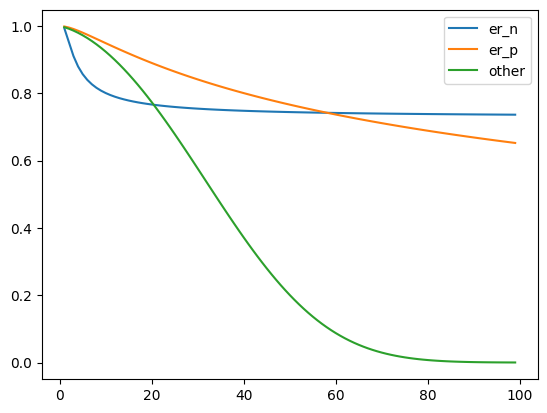

In [55]:
t = np.array(range(1,100))
plt.plot(t,get_surv_er_n(t), label='er_n')
plt.plot(t,get_surv_er_p(t), label='er_p')
plt.plot(t,get_surv_wo_age(t),label='other')
plt.legend()

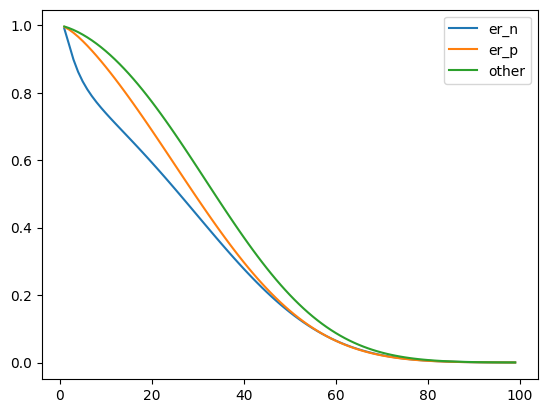

In [56]:
t = np.array(range(1,100))
plt.plot(t,get_surv_er_n(t)*get_surv_wo_age(t), label='er_n')
plt.plot(t,get_surv_er_p(t)*get_surv_wo_age(t), label='er_p')
plt.plot(t,get_surv_wo_age(t),label='other')
plt.legend()

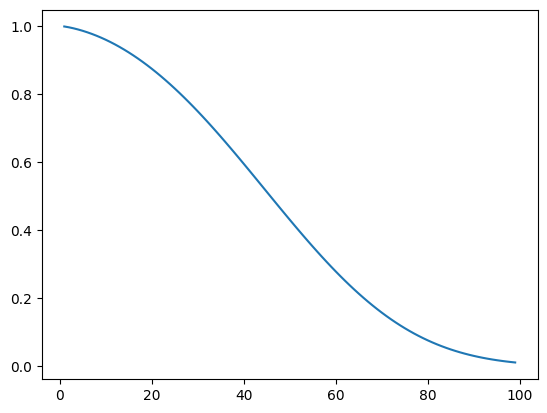

In [49]:
t = np.array(range(1,100))
plt.plot(t,get_surv(t))

In [ ]:
age = np.array(range(0,100))
plt.plot(age, get_bo(age))


In [ ]:
(age/10)**2 - 34.23391957

In [37]:
np.sqrt(34.23391957)*10

58.50975950215485

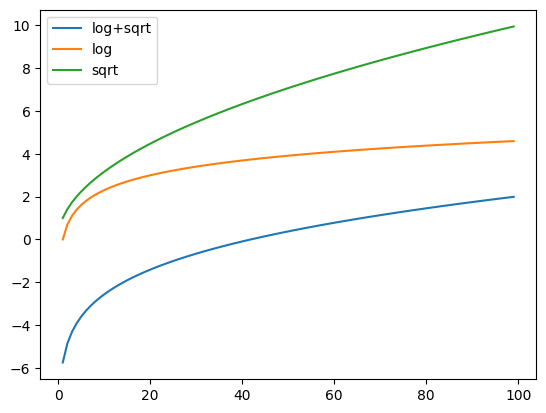

In [44]:
t = np.array(range(1,100))
plt.plot(t,-6.05+1.1*np.log(t)+0.3*np.sqrt(t),label='log+sqrt')
plt.plot(t,np.log(t),label='log')
plt.plot(t,np.sqrt(t),label='sqrt')
plt.legend()

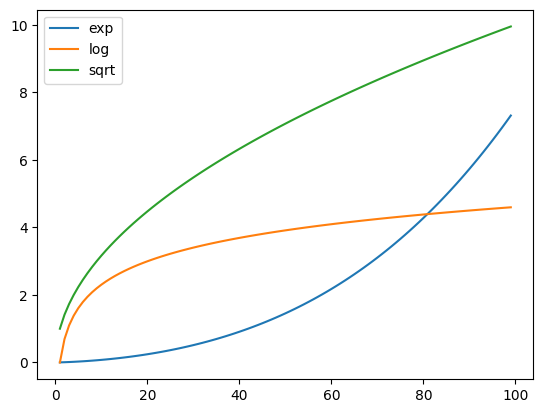

In [45]:
t = np.array(range(1,100))
plt.plot(t,np.exp(-6.05+1.1*np.log(t)+0.3*np.sqrt(t)),label='exp')
plt.plot(t,np.log(t),label='log')
plt.plot(t,np.sqrt(t),label='sqrt')
plt.legend()